In [2]:
import os
import json

import numpy as np
import torch

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns


## Size of dataset

In [6]:
dataset_keys = ('train', 'val', 'test')
dataset_sizes = dict()
for dataset in dataset_keys:
    with open(f'data/splits/{dataset}.txt') as f:
        size = len(f.readlines())
        dataset_sizes[dataset] = size

print(f'total size: {sum(dataset_sizes.values())}')
print(dataset_sizes)

total size: 52453
{'train': 36589, 'val': 5320, 'test': 10544}


## Labels

In [21]:
labels = dict()
for fname in tqdm(list(os.listdir(os.path.join('data', 'annotations')))):
    with open(os.path.join('data', 'annotations', fname), 'r') as fid:
        anno = json.load(fid)
        for obj in anno['objects']:
            label = obj['label']
            if label in labels:
                labels[label] += 1
            else:
                labels[label] = 1

100%|██████████| 41909/41909 [00:03<00:00, 11332.88it/s]


In [22]:
print(f'number of unique labels: {len(labels)}')

number of unique labels: 401


In [24]:
labelToNum = dict(zip(labels, range(len(labels))))

### Distribution

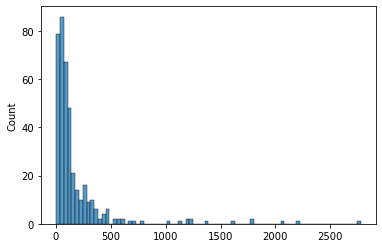

In [157]:
sorted_labels = sorted(labels.items(), key=lambda x: -x[1])
sns.histplot(x=dict(sorted_labels[1:]).values())
plt.show()

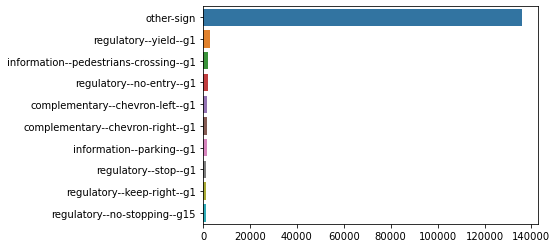

In [151]:
def make_plot(sorted_labels):
    y,x = list(zip(*sorted_labels))
    sns.barplot(x=list(x), y=list(y))
    plt.show()

make_plot(sorted_labels[:10])

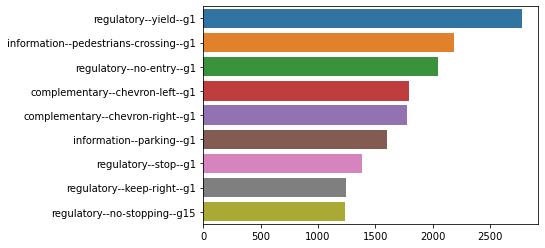

In [152]:
make_plot(sorted_labels[1:10])

how many labels occur more than 100 times

In [183]:
np.sum(np.array(list(labels.values())) > 500)

23

## Dataset

In [28]:
class MapillaryDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, dataset_key, num_images):
        """ 
        dataset_key (string): "train", "test" or "val" 
        num_images (int): in range 1 to len(dataset)
        """
        assert dataset_key in dataset_keys
        assert num_images > 0 and num_images <= dataset_sizes[dataset_key]

        self.root = root
        self.transforms = transforms
        self.dataset_key = dataset_key
        self.dataset = list(sorted(os.listdir(os.path.join(root, dataset_key, "images"))))[:num_images]

    def __getitem__(self, idx):
        # load images
        image_key = self.dataset[idx]
        img_path = os.path.join(self.root, self.dataset_key, "images", image_key)
        
        # find annotations
        with open(os.path.join('data', 'annotations', f'{image_key[:-4]}.json'), 'r') as fid:
            anno = json.load(fid)

        with Image.open(img_path) as img:
            img = img.convert("RGB")

            # get bounding box coordinates
            rects = Image.new('RGBA', img.size)
            #rects_draw = ImageDraw.Draw(rects)

            boxes = []
            labels = []
            for obj in anno['objects']:
                xmin = obj['bbox']['xmin']
                ymin = obj['bbox']['ymin']
                xmax = obj['bbox']['xmax']
                ymax = obj['bbox']['ymax']
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(labelToNum[obj['label']])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.dataset)

In [29]:
myDataset = MapillaryDataset(root="data", transforms=None, dataset_key="train", num_images=1000)

In [30]:
myDataset[0]

(<PIL.Image.Image image mode=RGB size=4160x3120 at 0x21D7A1C1370>,
 {'boxes': tensor([[2187.6562, 1669.6875, 2225.2344, 1707.7734],
          [2511.6406, 1391.6602, 2623.3594, 1508.9648],
          [2562.4219, 1298.7305, 2645.7031, 1389.3750],
          [1480.7812, 1327.6758, 1576.2500, 1421.3672]]),
  'labels': tensor([1, 2, 0, 3]),
  'image_id': tensor([0]),
  'area': tensor([ 1431.1981, 13105.1328,  7548.9897,  8944.6016])})